# Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [2]:
raw_data10 = pd.read_csv('data/scenario10.labeled', delimiter='\s+')

In [3]:
def parse_data(raw):
    data = raw
    data['Date'] = data['Date'].map(str) + " " + data['flow']
    data.sort_values(by='Date', inplace=True)
    data.drop(['Date'], axis=1, inplace=True)

    src_ip_port = data['Prot'].map(str).str.split(':', n=1, expand = True)
    dst_ip_port = data['IP'].map(str).str.split(':', n=1, expand = True)
    data['src_ip'] = src_ip_port[0]
    data['src_port'] = src_ip_port[1]
    data['dst_ip'] = dst_ip_port[0]
    data['dst_port'] = dst_ip_port[1]

    data.drop(['flow', 'Src','Packets', 'Bytes', 'Flows', 'Prot', 'IP', 'Label', 'Labels'], axis=1, inplace=True)
    data.rename(columns={'start':'duration','Durat':'protocol', 'Addr:Port':'flags', 'Dst':'tos', 'IP.1':'packets', 'Addr:Port.1':'bytes', 'Flags':'flows', 'Tos':'label'}, inplace=True)
    data['protocol_cat'] = pd.Categorical(data['protocol'], categories=data['protocol'].unique()).codes
    data['label_num'] = data['label'].apply(lambda x: 1 if x == 'Botnet' else 0)
    
    return data

In [4]:
data10 = parse_data(raw_data10)

   duration protocol  flags  tos  packets    bytes  flows       label  \
0     0.002      TCP  FRPA_    0        4      321      1  Background   
1     4.995      UDP    INT    0      617    40095      1  Background   
2     4.996      UDP    INT    0     1290  1909200      1  Background   
3     0.000      TCP     A_    0        1       66      1  Background   
4     0.000      TCP   FPA_    0        2      169      1  Background   

           src_ip src_port          dst_ip dst_port  protocol_cat  label_num  
0   147.32.86.166    33426  212.24.150.110    25443             0          0  
1     82.39.2.249    41915    147.32.84.59    43087             1          0  
2    147.32.84.59    43087     82.39.2.249    41915             1          0  
3   147.32.86.166    42020   147.32.192.34      993             0          0  
4  212.24.150.110    25443   147.32.86.166    33426             0          0  
['Background' 'LEGITIMATE' 'Botnet']


# Flow data discretization task

In [5]:
# Split the data into the normal and infected hosts
infected_ip = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207', '147.32.84.208', '147.32.84.209']
selected_infected = 0

normal_ip = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

infected_data = data10[(data10['src_ip']== infected_ip[selected_infected])]
normal_data = data10[data10['src_ip'].isin(normal_ip)]

## Statistic differences of normal and infected features

In [6]:
def print_stat(feature):
    print(feature + "   -   Normal     -   Mean: " + str(round(normal_data[feature].mean(),2)) + "     Std: " + str(round(normal_data[feature].std(),2)))
    print(feature + "   -   Infected   -   Mean: " + str(round(infected_data[feature].mean(),2)) + "     Std: " + str(round(infected_data[feature].std(),2)))

In [7]:
for feature in data10.select_dtypes([np.number]).columns:
    print_stat(feature)

duration   -   Normal     -   Mean: 0.03     Std: 0.31
duration   -   Infected   -   Mean: 0.55     Std: 1.44
tos   -   Normal     -   Mean: 0.0     Std: 0.0
tos   -   Infected   -   Mean: 0.0     Std: 0.0
packets   -   Normal     -   Mean: 1.77     Std: 33.22
packets   -   Infected   -   Mean: 15.84     Std: 102.15
bytes   -   Normal     -   Mean: 781.56     Std: 34258.15
bytes   -   Infected   -   Mean: 14104.12     Std: 84291.2
flows   -   Normal     -   Mean: 1.0     Std: 0.0
flows   -   Infected   -   Mean: 1.0     Std: 0.0
protocol_cat   -   Normal     -   Mean: 0.94     Std: 0.24
protocol_cat   -   Infected   -   Mean: 1.94     Std: 0.31
label_num   -   Normal     -   Mean: 0.0     Std: 0.02
label_num   -   Infected   -   Mean: 1.0     Std: 0.0


## Plot interesting differences

In [8]:
def plot_feature(feature1, feature2):
    plt.figure(figsize=(15,5))
    plt.scatter(infected_data[feature1], infected_data[feature2], label='infected_data')
    plt.scatter(normal_data[feature1], normal_data[feature2], label='normal_data')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend()
    plt.title("Difference between a normal and an infected host \n compared using: "+ feature1 + " and " + feature2)
#     plt.savefig("difference_"+feature1+"_"+feature2+".png")
    plt.show()

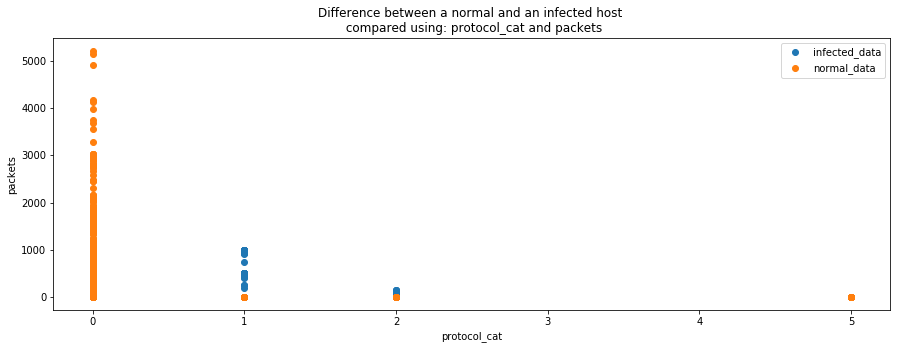

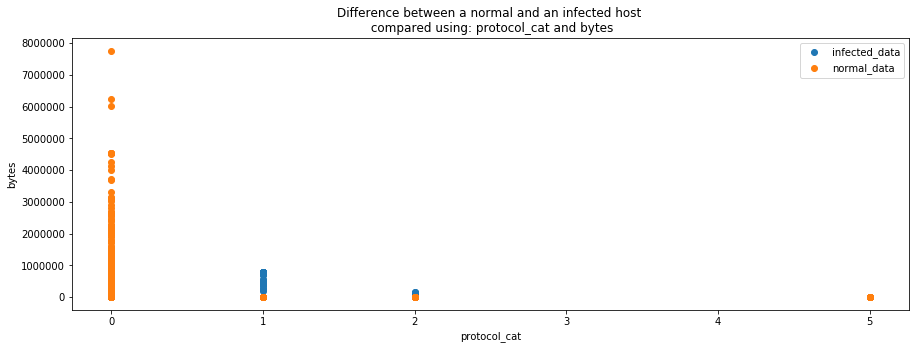

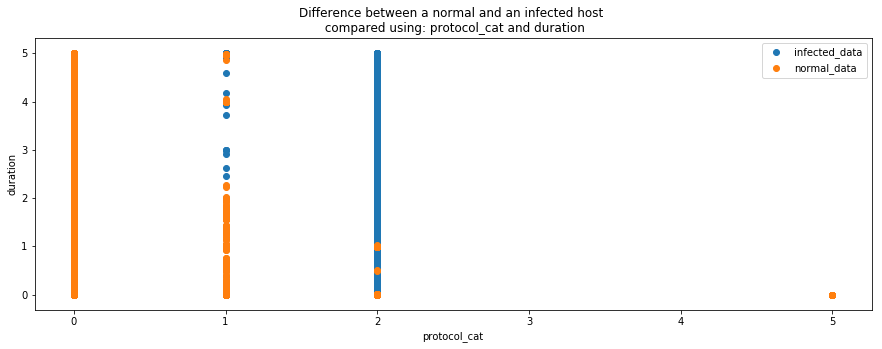

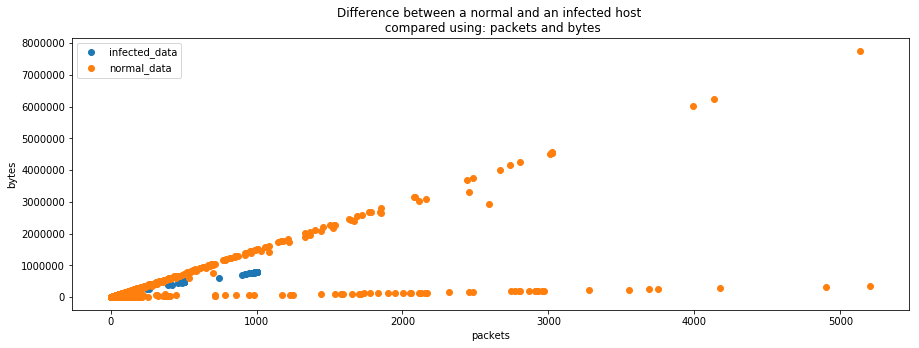

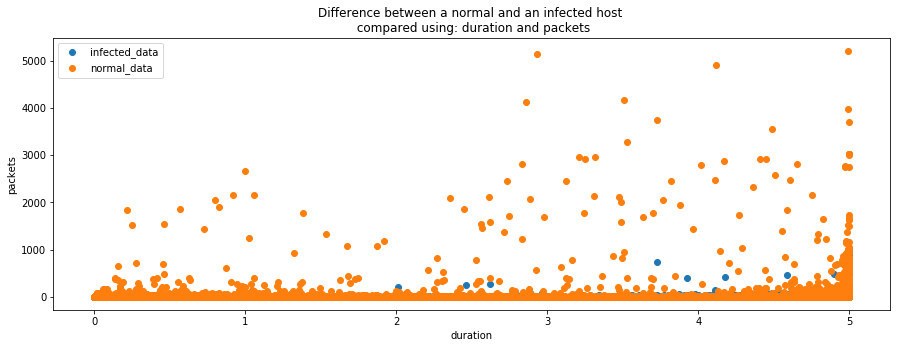

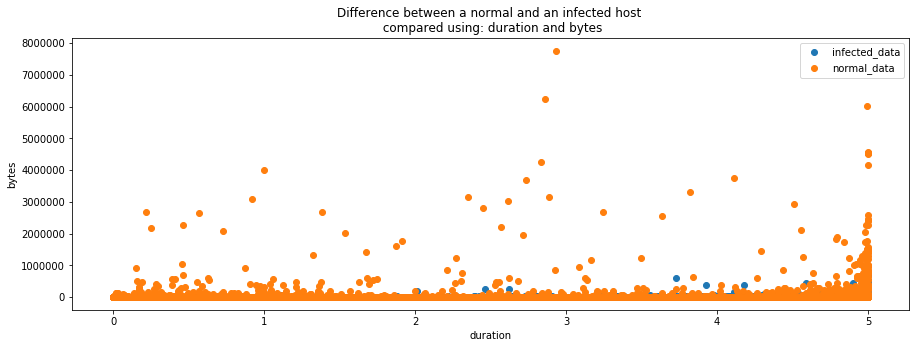

In [9]:
# Compare the features with clear differences between normal and infected hosts

plot_feature('protocol_cat', 'packets')
plot_feature('protocol_cat', 'bytes')
plot_feature('protocol_cat', 'duration')
plot_feature('packets', 'bytes')
plot_feature('duration', 'packets')
plot_feature('duration', 'bytes')

## Discretization of interesting feature combinations using netflow encoding

In [10]:
# Map numerical feature
class map_numerical:
    def __init__(self, data, feature, num_percentiles = 5):
#         extract feature from dataframe
        self.data = data[feature].reset_index(drop=True)
#         Create array with percentile slices
        self.percentiles = np.arange(1/num_percentiles, 1, 1/num_percentiles)
#         Define percentile boundries based on values
        self.percentiles_values = list(map(lambda x: np.percentile(self.data,x*100), self.percentiles))
#         Save number of percentiles for netflow algorithm
        self.num_percentiles = num_percentiles
        
#         Calculate mapping value for specific row
    def mapping(self, row):
        value = self.data[row]
        previous_boundary = 0
#         Check percentile based on row boundries
        for i,boundary in enumerate(self.percentiles_values):
            if value >= previous_boundary and value < boundary:
                return i
            previous_boundary = boundary
        return self.num_percentiles - 1
    
#     Return number of possible values/bins
    def mapping_size(self):
        return self.num_percentiles

In [11]:
# Map categorical feature
class map_categorical:
    def __init__(self, data, feature):
#         extract feature from dataframe
        self.data = data[feature].reset_index(drop=True)
#         Set categories in array and use index as numerical representation
        self.categories = self.data.unique()
#         Scve number of categories for netflow algorithm
        self.num_categories = self.data.nunique()
        
#         Return mapping value based on index of categorical value array
    def mapping(self, row):
        value = self.data[row]
        return np.where(self.categories == value)[0][0]
    
#     Return number of possible values/bins
    def mapping_size(self):
        return self.num_categories

In [12]:
# Netflow algorithm as defined in paper
def encode_netflow(features, row):
    code = 0
    space_size = 1
    for feature in features:
        space_size *= feature.mapping_size()
    for feature in features:
        mapping_size = feature.mapping_size()
        code += feature.mapping(row) * space_size / mapping_size
        space_size /= mapping_size
    return code

In [13]:
# Encode full serie
def encode_series(features, num_rows):
    encoded = list()
    for i in range(0, num_rows):
        encoded.append(encode_netflow(features, i))
    return encoded

## Test interesting feature combinations

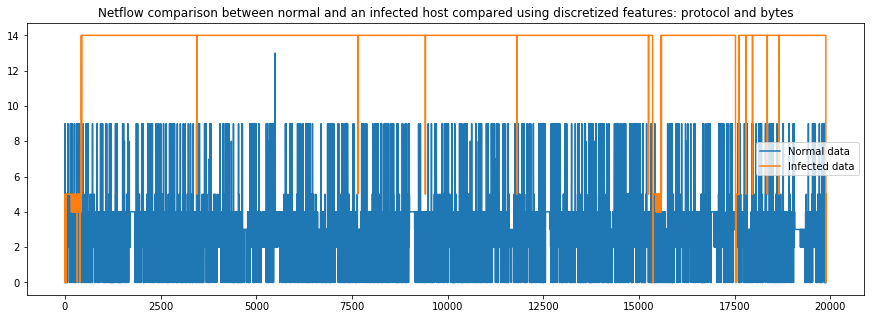

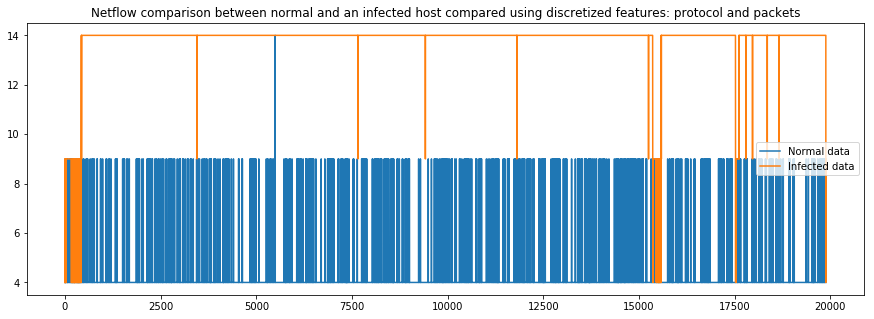

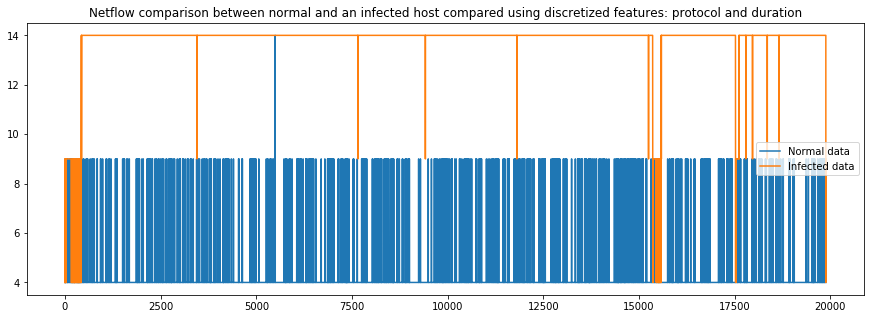

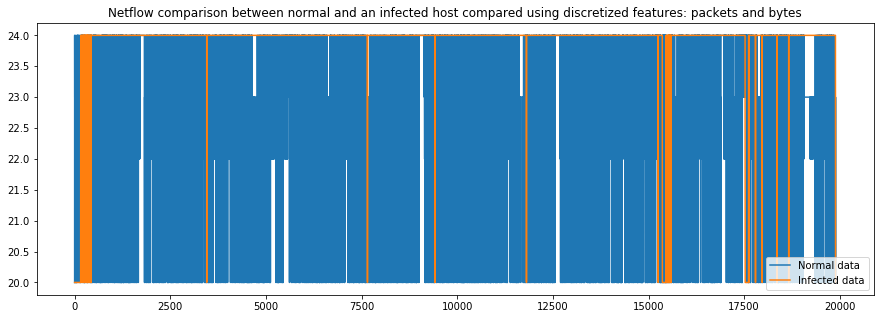

In [14]:
def test_netflows(feature1, feature2, cat1 = False, cat2 = False):
    limit = min(len(infected_data), len(normal_data))
    
    # Map the data
    if cat1:
        inf_feat1 = map_categorical(infected_data, feature1)
        norm_feat1 = map_categorical(normal_data, feature1)
    else:
        inf_feat1 = map_numerical(infected_data, feature1)
        norm_feat1 = map_numerical(normal_data, feature1)
    
    if cat2:    
        inf_feat2 = map_categorical(infected_data, feature2)
        norm_feat2 = map_categorical(normal_data, feature2)
    else:
        inf_feat2 = map_numerical(infected_data, feature2)
        norm_feat2 = map_numerical(normal_data, feature2)
    
    # Encode the data
    inf_encoded_serie = encode_series([inf_feat1,inf_feat2], limit)
    norm_encoded_serie = encode_series([norm_feat1,norm_feat2], limit)

    # Plot comparison between normal and infected data
    plt.figure(figsize=(15,5))
    plt.plot(norm_encoded_serie, label="Normal data")
    plt.plot(inf_encoded_serie, label="Infected data")
    plt.legend()
    plt.title("Netflow comparison between normal and an infected host compared using discretized features: "+ feature1 + " and " + feature2)
    plt.show()

test_netflows('protocol', 'bytes', cat1 = True)
test_netflows('protocol', 'packets', cat1 = True)
test_netflows('protocol', 'duration', cat1 = True)
test_netflows('packets', 'bytes')

## Discretize all data at once

In [15]:
try:
    all_encoded_serie = np.genfromtxt('discretized_proto_bytes.csv',delimiter=',')
except:
    all_proto = map_categorical(data10, 'protocol')
    all_byte = map_numerical(data10, 'bytes')
    all_encoded_serie = encode_series([all_proto,all_byte], len(data10))
    np.savetxt("discretized_proto_bytes.csv", all_encoded_serie, delimiter=",")

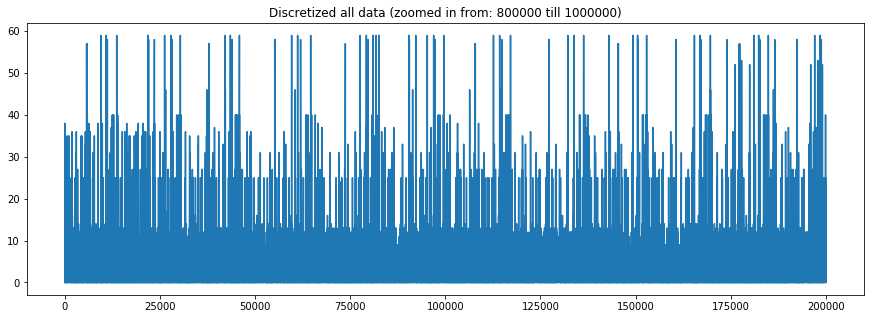

In [16]:
# Only plot a part of the discretized data, as it would be too much to distinguish otherwise
start = 800000
end = 1000000
plt.figure(figsize=(15,5))
plt.plot(all_encoded_serie[start:end], label="Data")
plt.title("Discretized all data (zoomed in from: "+str(start)+" till "+str(end)+")")
plt.show()

# Botnet profiling

In [17]:
def create_markov_chain(levels, n_elements):    
    # Use the zip function to help us generate sliding windows
    # Concatentate the tokens into sliding windows            
    sliding_windows = list(zip(*[levels[i:] for i in range(n_elements)]))
    markov_chain = {}
    for sliding_window in sliding_windows:
        last_element = sliding_window[-1]
        window_base = sliding_window[:-1]
        if window_base not in markov_chain:
            markov_chain.update({window_base: {}})
            
        known_transitions = markov_chain[window_base]
        if last_element not in known_transitions:
            known_transitions.update({last_element: 1})
        else:
            known_transitions[last_element] += 1
    return markov_chain


def classify_using_markov_chain(training, test_sets, threshold, n_elements):    
    markov_chain = create_markov_chain(training, n_elements)
    
    # We need to set the first n_elements - 1 values to normal, 
    # because we detect abnormalities for the last element of the sequence.
    # If a certain index is abnormal, it is thus actually index + n_elements - 1,
    for infected, host_ip, test_set in test_sets:
#         print('Infected: ', infected)
        length = len(test_set)
        detected_list = [0]*(n_elements - 1)
        sequence_probabilities = []
        for i in range(length):
            if i >= length - n_elements:
                # Take the last n_elements values into account if 
                # we are at the end
                sequence = test_set[-n_elements:]
            else:
                sequence = test_set[i:i+n_elements]

            base = tuple(sequence[:-1])
            head = sequence[-1]

            if base not in markov_chain:
                markov_chain.update({base: {}})
                
            last_elements = markov_chain[base]
                
            base_occurences = sum(last_elements.values())
            
            # Calculate the probability that some sequence in the test set was seen in the training set as well
            if base_occurences == 0 or head not in last_elements:
                sequence_probability = 0
            else:
                occurences = last_elements[head]
                sequence_probability = occurences / base_occurences
                
            sequence_probabilities.append(sequence_probability)

        mean_seq_prob = np.mean(sequence_probabilities)
        # Classify with threshold 0.5 (when more likely to be like the training host, classify to that class. 
        # Otherwise classify as other class)
        inf_pred = mean_seq_prob > 0.5
        
        plt.figure(figsize=(15,5))
        plt.ylim((-0.05,1.05))
        plt.plot(sequence_probabilities[0:10000], label=ip)
        plt.title("Markov chain classifying of host:" + str(host_ip) + " against a botnet profile.  Avg: "+ "{0:.2f}".format(mean_seq_prob) + "  Botnet: " + str(inf_pred))
        plt.show()

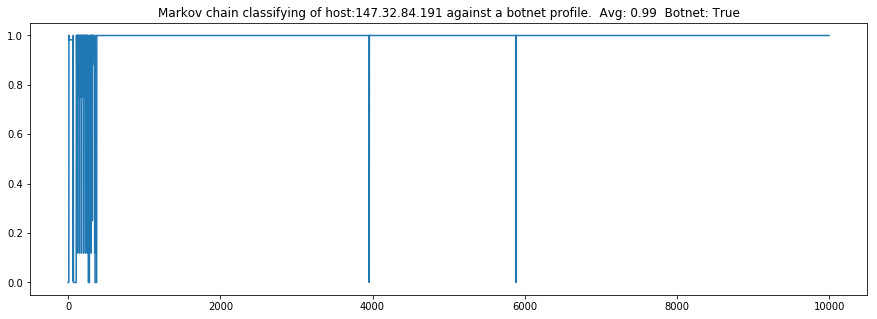

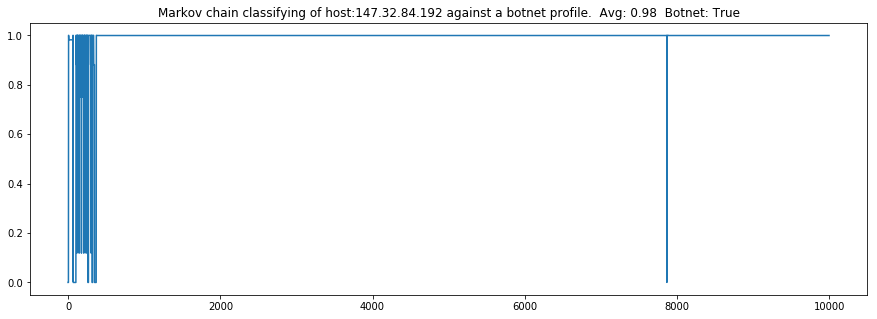

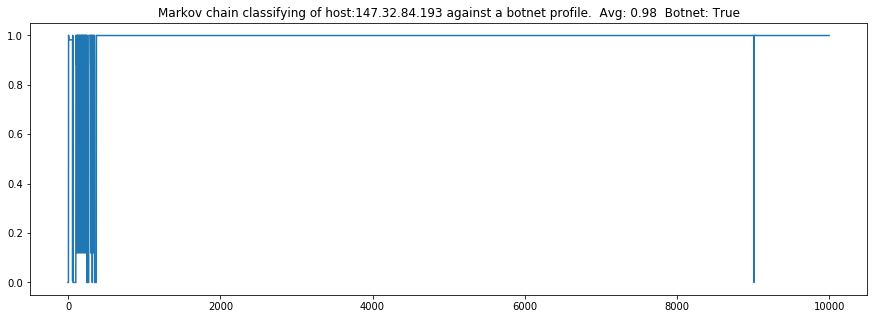

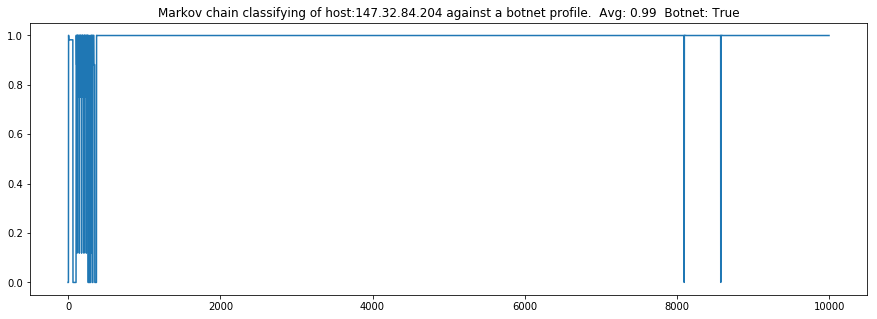

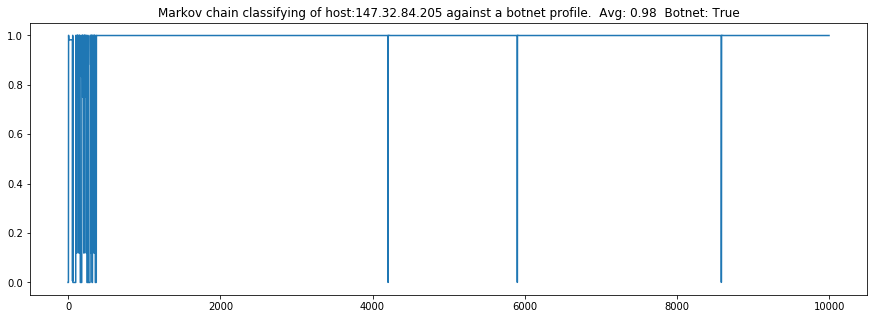

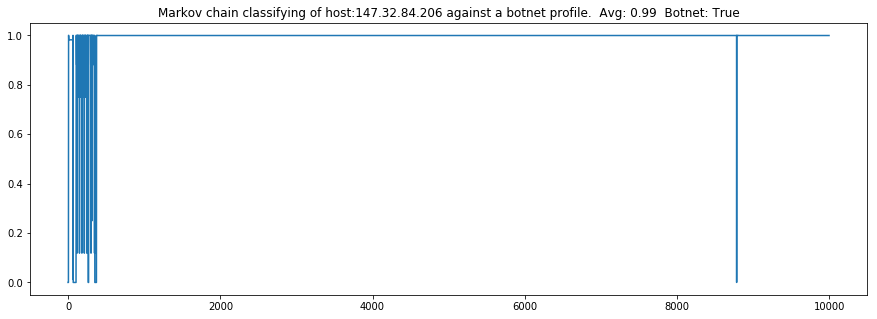

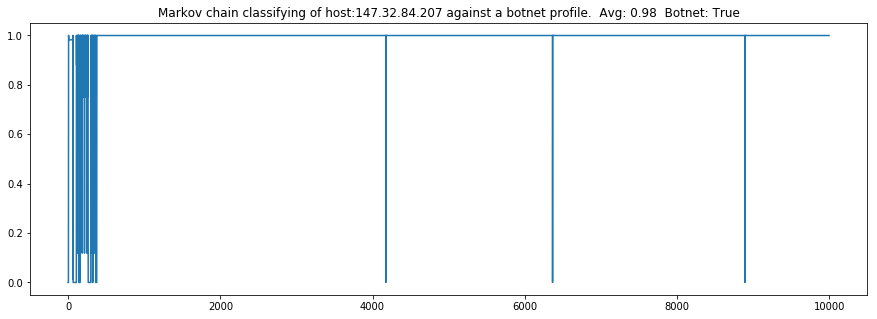

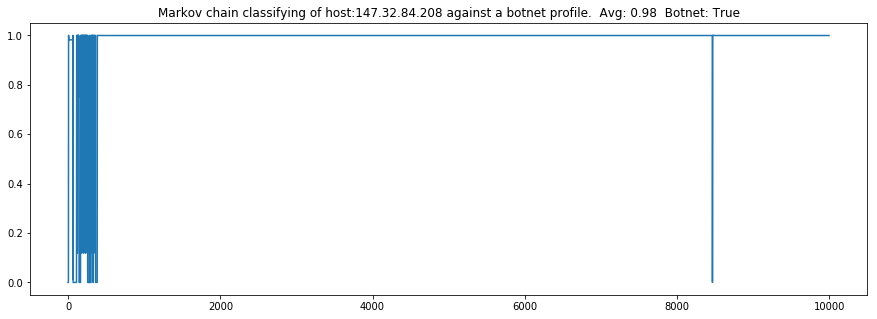

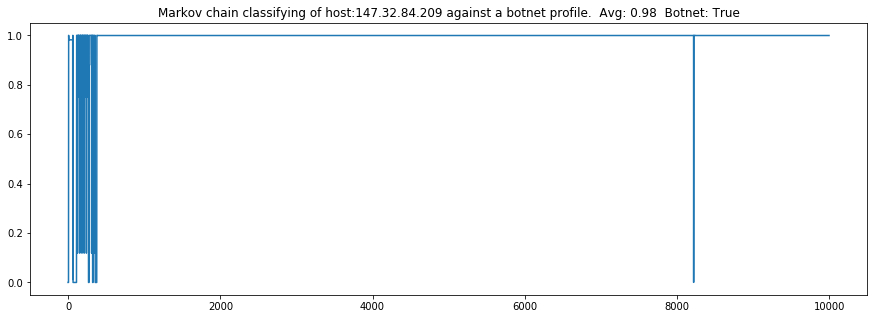

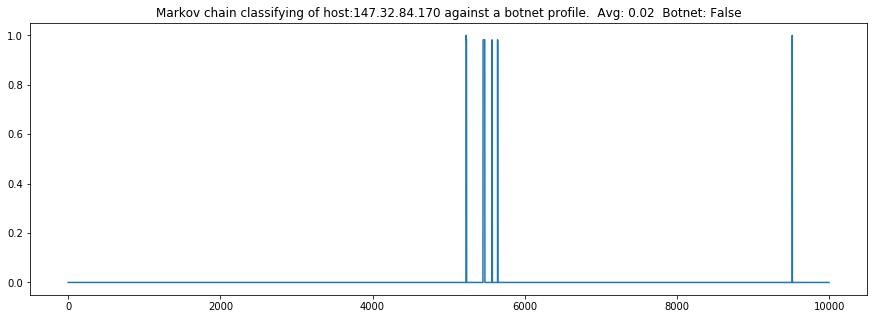

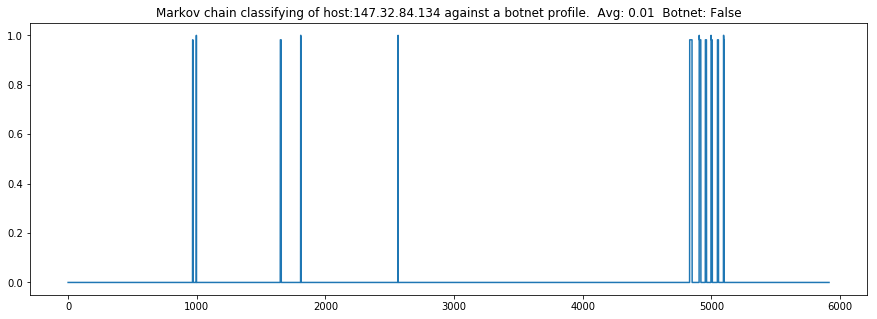

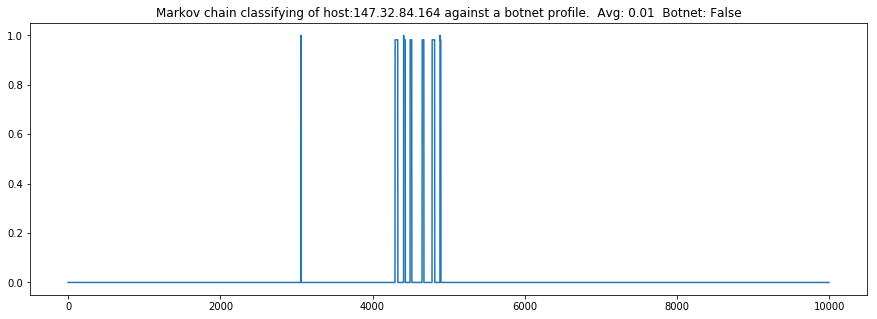

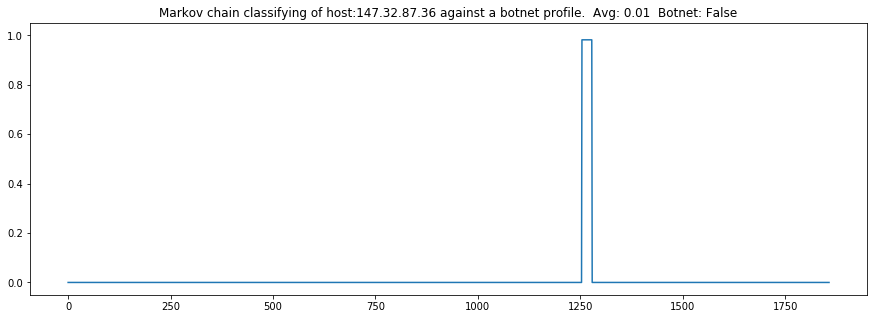

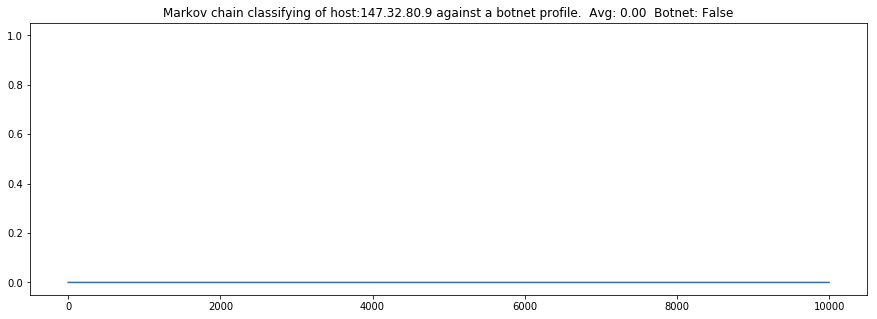

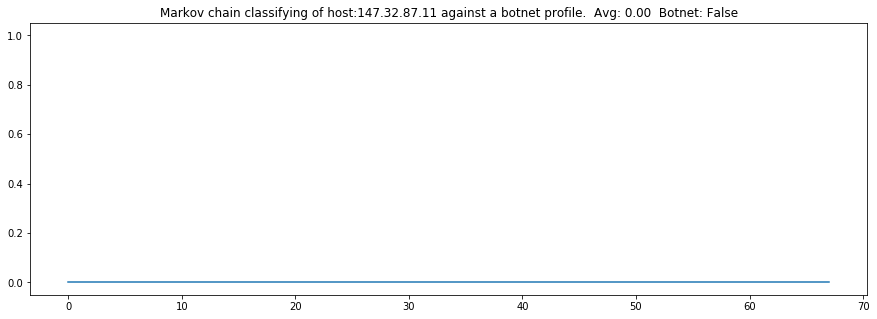

In [18]:
# prepare for markov chain
hosts = infected_ip + normal_ip
hosts.pop(selected_infected)
data10['discretize'] = all_encoded_serie

tests = []
for ip in hosts:
    tests.append((ip in infected_ip, ip, data10[data10['src_ip']==ip]['discretize'].values))
    
training = data10[data10['src_ip']==infected_ip[selected_infected]]['discretize'].values
classify_using_markov_chain(training, tests, 0.9, 20)

## Creating a CSV to find optimal window size

In [19]:
# results = pd.DataFrame()
# for i in range(1,51):
#     results[i] = classify_using_markov_chain(training, tests, 0.9, i)
# results.to_csv('markov_comparison_size.csv')

## Comparing feature patterns

In [20]:
inf_hosts = infected_ip.copy()
inf_hosts.pop(selected_infected)

'147.32.84.165'

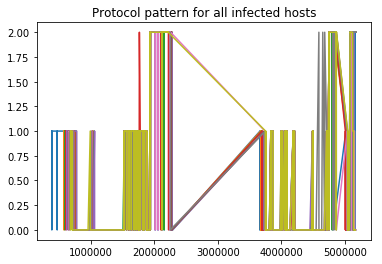

In [21]:
for ih in inf_hosts:
    plt.plot(data10[data10['src_ip']==ih]['protocol_cat'], label=ih)
    plt.title("Protocol pattern for all infected hosts")
plt.savefig('Protocol_pattern.png')
plt.show()

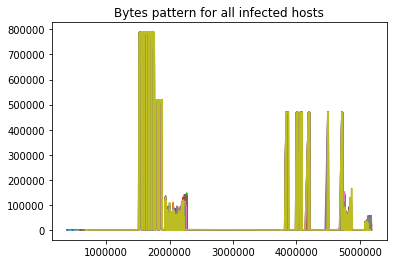

In [23]:
for ih in inf_hosts:
    plt.plot(data10[data10['src_ip']==ih]['bytes'], label=ih)
    plt.title("Bytes pattern for all infected hosts")
plt.savefig('Byte_pattern.png')
plt.show()